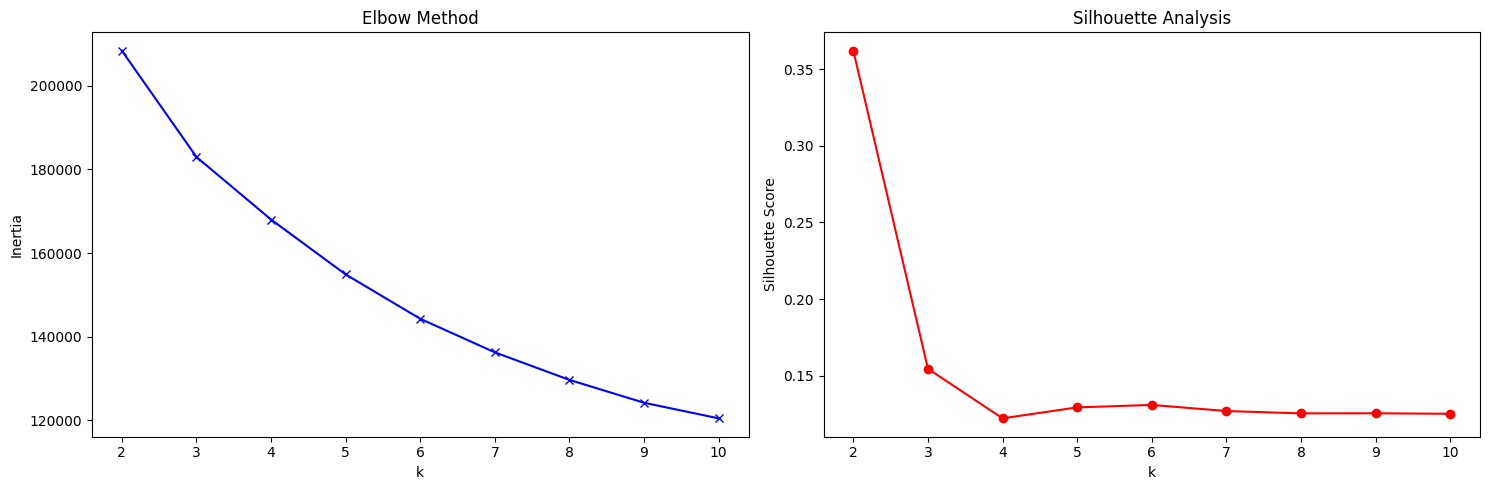

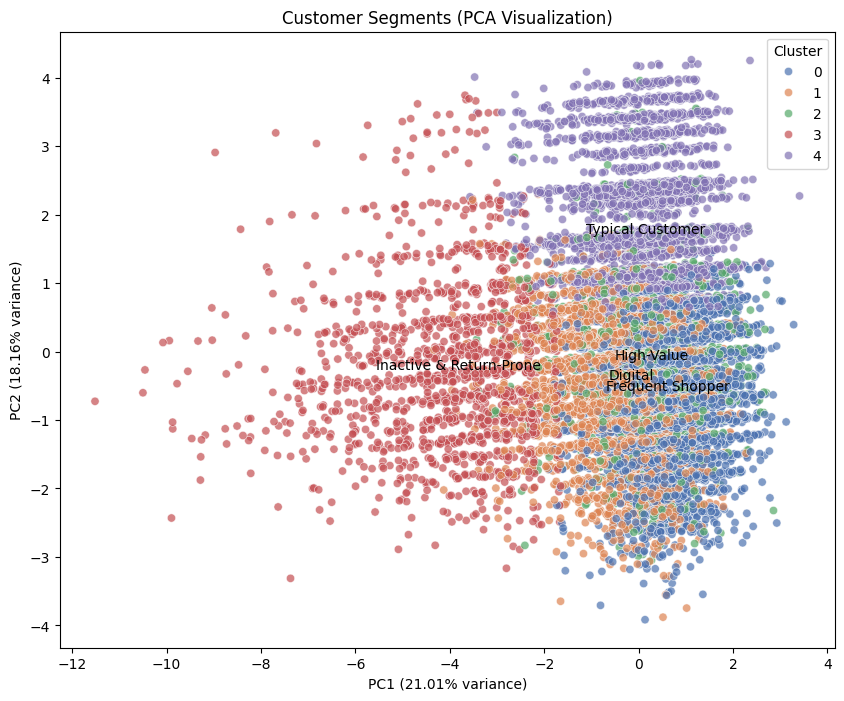

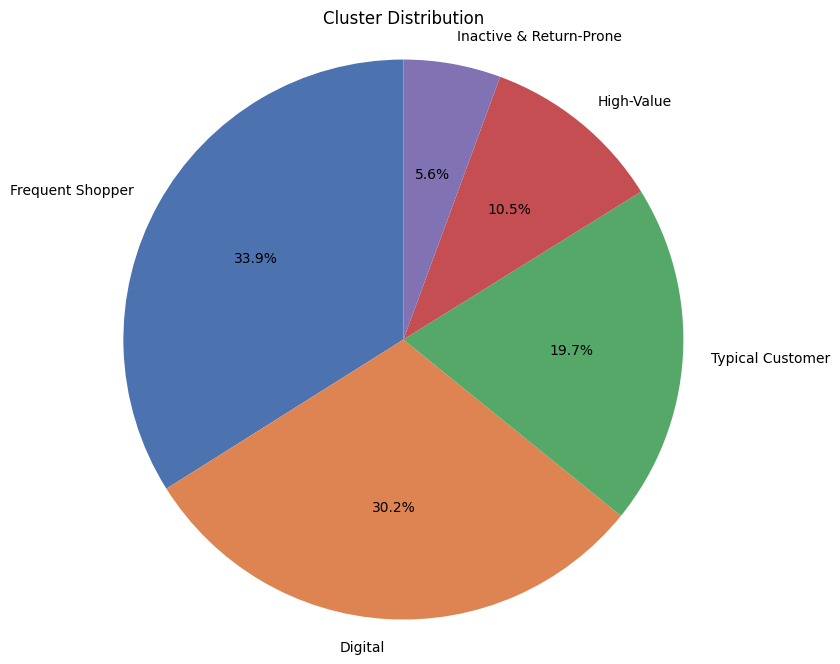

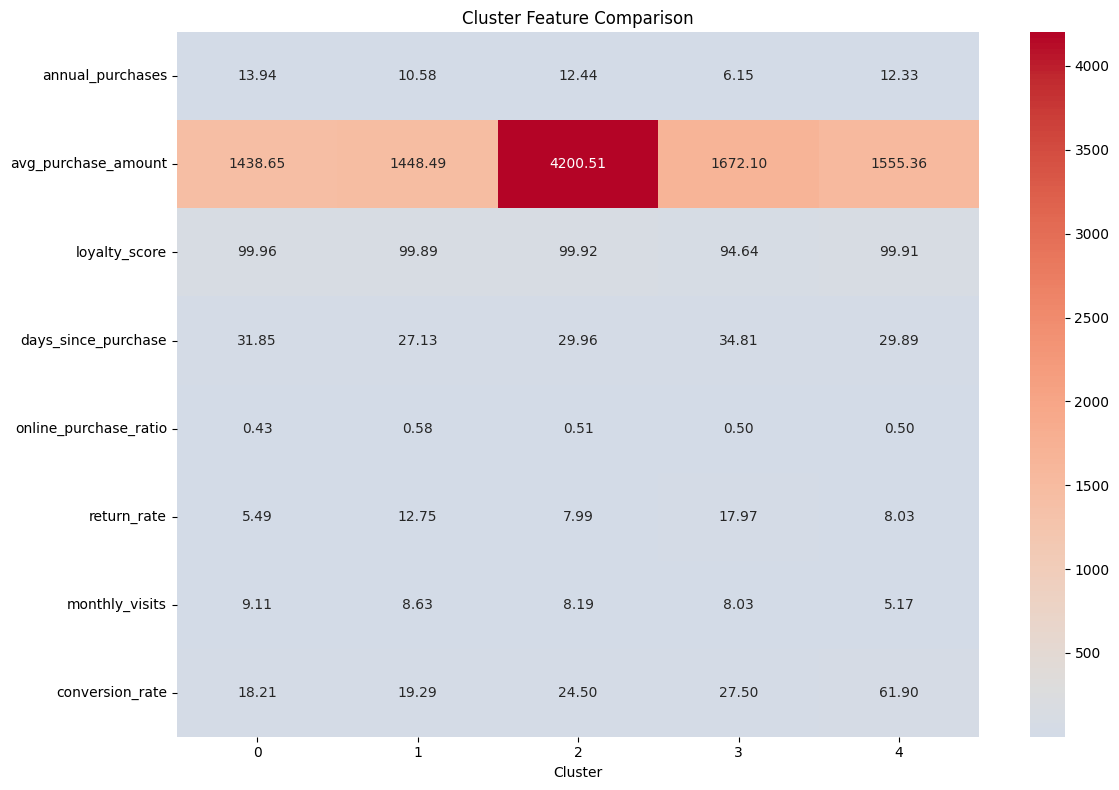


=== Marketing Segmentation Report ===


Cluster 0: Frequent Shopper
Size: 10182 (33.9%)
Characteristics:
annual_purchases: 13.94 (Z-score: 0.55)
avg_purchase_amount: 1438.65 (Z-score: -0.28)
loyalty_score: 99.96 (Z-score: 0.24)
days_since_purchase: 31.85 (Z-score: 0.34)
online_purchase_ratio: 0.43 (Z-score: -0.47)
return_rate: 5.49 (Z-score: -0.36)
monthly_visits: 9.11 (Z-score: 0.38)
conversion_rate: 18.21 (Z-score: -0.43)

Cluster 1: Digital
Size: 9067 (30.2%)
Characteristics:
annual_purchases: 10.58 (Z-score: -0.41)
avg_purchase_amount: 1448.49 (Z-score: -0.28)
loyalty_score: 99.89 (Z-score: 0.19)
days_since_purchase: 27.13 (Z-score: -0.53)
online_purchase_ratio: 0.58 (Z-score: 0.53)
return_rate: 12.75 (Z-score: 0.36)
monthly_visits: 8.63 (Z-score: 0.21)
conversion_rate: 19.29 (Z-score: -0.39)

Cluster 2: High-Value
Size: 3157 (10.5%)
Characteristics:
annual_purchases: 12.44 (Z-score: 0.12)
avg_purchase_amount: 4200.51 (Z-score: 2.09)
loyalty_score: 99.92 (Z-score: 0.21)
days_since

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import datetime

# Enhanced cluster naming with stricter thresholds and uniqueness
def assign_cluster_names(cluster_summary, centroids):
    names = {}
    for cluster in cluster_summary.index:
        # Normalized centroid values for relative comparison
        z_scores = centroids[cluster]
        characteristics = []

        # Define thresholds for significant deviation (e.g., 0.5 standard deviations)
        if z_scores[0] > 0.5 and z_scores[1] > 0.5:  # annual_purchases & avg_purchase_amount
            characteristics.append("Premium Frequent")
        elif z_scores[0] > 0.5:
            characteristics.append("Frequent Shopper")
        elif z_scores[1] > 0.5:
            characteristics.append("High-Value")

        if z_scores[2] > 0.5:  # loyalty_score
            characteristics.append("Loyal")
        if z_scores[4] > 0.5:  # online_purchase_ratio
            characteristics.append("Digital")
        if z_scores[3] > 0.5:  # days_since_purchase
            characteristics.append("Inactive")
        elif z_scores[6] > 0.5 and z_scores[0] < -0.5:  # monthly_visits & low purchases
            characteristics.append("Browsers")
        if z_scores[5] > 0.5:  # return_rate
            characteristics.append("Return-Prone")

        # Ensure unique and concise names
        name = " & ".join(characteristics[:2]) if characteristics else "Typical Customer"
        if name in names.values():
            name += f" (Cluster {cluster})"
        names[cluster] = name
    return names

# Load and preprocess data
df = pd.read_csv('customer_data_poisson.csv')
df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'])
df['days_since_purchase'] = (datetime.now() - df['last_purchase_date']).dt.days

# Feature selection
features = [
    'annual_purchases', 'avg_purchase_amount', 'loyalty_score',
    'days_since_purchase', 'online_purchase_ratio', 'return_rate',
    'monthly_visits', 'conversion_rate'
]

# Handle missing values (if any)
df = df.dropna(subset=features)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Determine optimal number of clusters using silhouette score and elbow method
silhouette_scores = []
inertias = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow and Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(K, inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Optimal clusters (manual selection or based on silhouette max)
n_clusters = 5  # Adjust based on analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster analysis
cluster_summary = df.groupby('Cluster')[features].mean().round(2)
cluster_sizes = df['Cluster'].value_counts()
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Convert back to original scale

# Assign names
cluster_names = assign_cluster_names(cluster_summary, kmeans.cluster_centers_)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']

# Visualizations
# 1. PCA Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='deep', alpha=0.7)
for i, name in cluster_names.items():
    plt.text(df_pca[df_pca['Cluster'] == i]['PC1'].mean(), 
             df_pca[df_pca['Cluster'] == i]['PC2'].mean(), 
             name, fontsize=10, ha='center')
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

# 2. Pie Chart
plt.figure(figsize=(10, 8))
plt.pie(cluster_sizes, labels=[cluster_names[i] for i in cluster_sizes.index], 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('deep', n_clusters))
plt.title('Cluster Distribution')
plt.axis('equal')
plt.show()

# 3. Feature Comparison Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary.T, annot=True, cmap='coolwarm', fmt='.2f', center=cluster_summary.mean().mean())
plt.title('Cluster Feature Comparison')
plt.tight_layout()
plt.show()

# Detailed cluster report
print("\n=== Marketing Segmentation Report ===\n")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}: {cluster_names[cluster]}")
    print(f"Size: {cluster_sizes[cluster]} ({cluster_sizes[cluster]/len(df)*100:.1f}%)")
    print("Characteristics:")
    for i, feature in enumerate(features):
        value = cluster_summary.loc[cluster, feature]
        z_score = kmeans.cluster_centers_[cluster][i]
        print(f"{feature}: {value:.2f} (Z-score: {z_score:.2f})")
    print("="*60)